In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.svm import LinearSVR
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error

from scipy.stats import ttest_1samp, uniform, randint, ttest_ind
from scipy import stats
from statsmodels.stats import weightstats as stests

In [3]:
%run CoreFunction.ipynb

In [4]:
plt.style.use('seaborn')

In [5]:
TEST_SIZE=0.15
n_comp = 0.95

In [6]:
scaler_min_max = MinMaxScaler()
scaler_z_score = StandardScaler()

# Electricity Load Forecast

## Support Vector Machine

In [7]:
def evaluate_svr(att, target, c, model_wrapper):
    svr = LinearSVR(epsilon=0.0, C=c, max_iter = 1000, tol = 0.001, random_state=42,  loss='squared_epsilon_insensitive', dual=False)
    if model_wrapper == "MultiOutputRegressor":
        svr_wrapped = MultiOutputRegressor(svr)
    elif model_wrapper == "RegressorChain":
        svr_wrapped = RegressorChain(svr)
    else: 
        return
    svr_wrapped.fit(att, target)            
    return svr_wrapped

In [8]:
@timeit
def get_model_results(PC_train, target_train, PC_test, target_test, c, model_wrapper):
    results = pd.DataFrame(columns=['C', 'mse_train', 'mae_train', 'rmse_train', 'r2_train', 'mse_test', 'mae_test', 'rmse_test', 'r2_test'])
    for i in range (0,len(c)):
        linear_SVR = evaluate_svr(PC_train, target_train, c[i], model_wrapper)
        mse, mae, rmse, r2 = evaluation_results(linear_SVR, PC_train, target_train)
        mse_test, mae_test, rmse_test, r2_test = evaluation_results(linear_SVR, PC_test, target_test)
        df = pd.DataFrame()
        df = {'C':c[i] , 'mse_train':mse, 'mae_train':mae, 'rmse_train':rmse, 'r2_train':r2, 'mse_test':mse_test, 'mae_test':mae_test, 'rmse_test':rmse_test, 'r2_test':r2_test}
        results = results.append(df, ignore_index = True)
    results = results.set_index('C')
    return results

## Read Price and Normalize Data

In [9]:
load_target, load_attribute, df_data_load = read_data("total load actual",  r"data\df_data_load_ts720_120_24.csv")

In [10]:
load_atribute_train, load_atribute_test, load_target_train, load_target_test, load_attribute_col_names = scaled_data(load_target, load_attribute, TEST_SIZE, scaler_z_score)

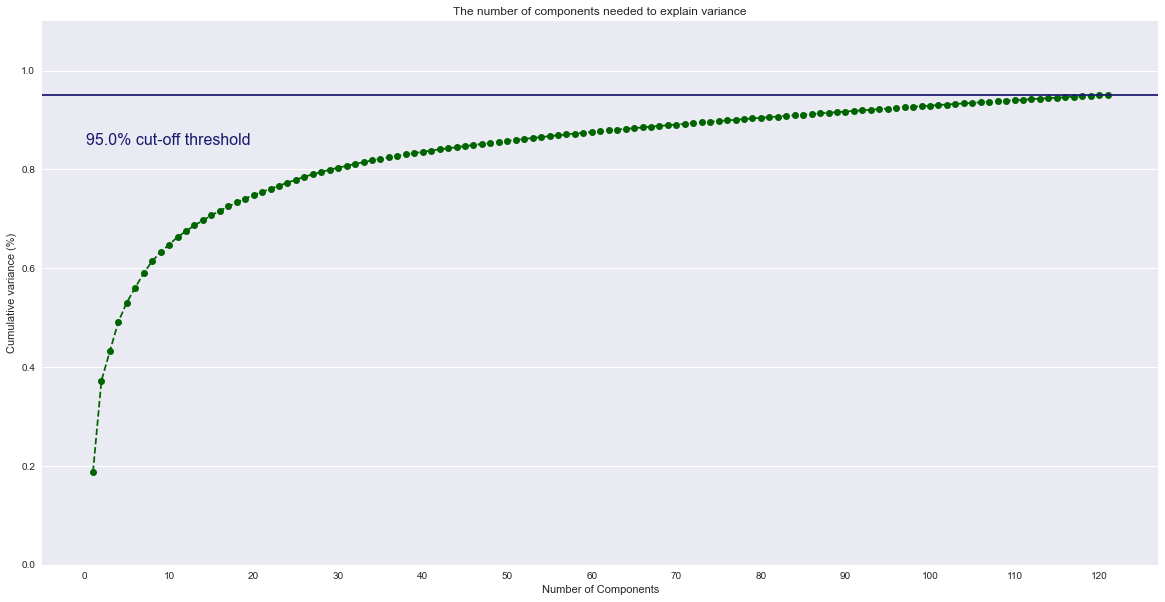

Transformed train shape: (29071, 121)
Transformed test shape: (5131, 121)
Function took 2.7725 seconds


In [11]:
most_important_features, PC_train, PC_test = PCA_feature_preprocessing(load_atribute_train, load_atribute_test, n_comp = n_comp, col_names = load_attribute.columns)

## Multi-Output Linear Support Vector Regression

Поддържаща векторна регресия (SVR)

Support Vector Machine може да се използва и като a регресионен метод, запазвайки всички основни характеристики, които характеризират алгоритъма, като:

- SVR има допълнителен регулируем параметър ε (епсилон). Стойността на епсилон определя ширината на ивицата около оценената функция (хиперравнина). Точките, които попадат в тази ивица, се считат за правилни прогнози и не се наказват от алгоритъма.
- Опорните вектори са точките, които попадат извън ивицата, а не само тези на границата.
- ξ  измерва разстоянието до точки извън ивицата и може да се контролира чрез параметър за регулиране C. 

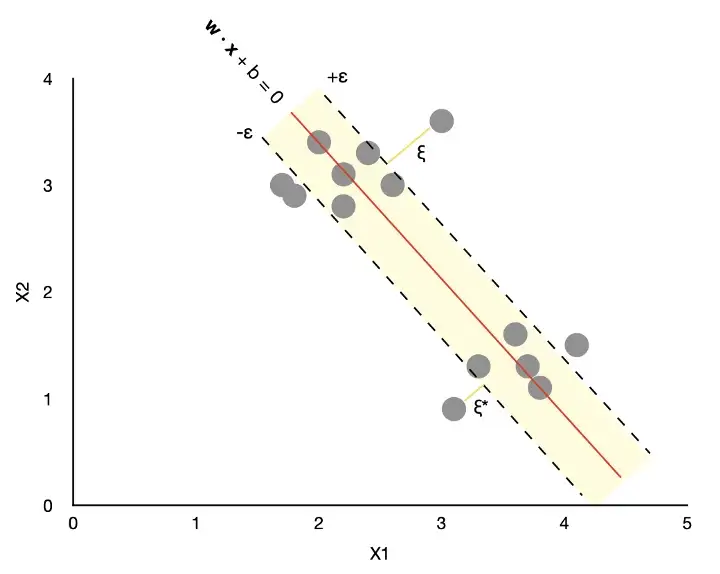

SVR е много по-гъвкав в сравнение с линейната регресия. Той може да улови промяната на наклона, докато простата линейна регресия има само един параметър на наклон. 

Множествената линейна регресия създава прогнозна равнина, която изглежда като плосък лист хартия. Междувременно SVR е по-скоро като мека тъкан, която можете да огъваме в пространството.

SVR не поддържа множествен изход и поради тази причина се нуждае от външни обвивки. В проекта са тествани MultiOutputRegressor и RegressorChain. 

### Search for Hyperparameters

Хиперпараметрите  loss='squared_epsilon_insensitive' и dual=False ускоряват неимоверно много оптимизацията, без да повлияват особено на производителността. Ще потърсим оптимални хиперпараметри.

In [23]:
c = [0.0001, 0.0005, 0.001, 0.01,  0.1, 1, 10, 100] 
res_mo_svr = get_model_results(PC_train, load_target_train, PC_test, load_target_test, c, "MultiOutputRegressor")
res_mo_svr
# с РСА трансформация на данните

Function took 422.1852 seconds


,mse_train,mae_train,rmse_train,r2_train,mse_test,mae_test,rmse_test,r2_test
C,,,,,,,,
0.0001,2.497120e+07,4431.194057,4997.106118,-0.204407,2.526869e+07,4464.961063,5026.730421,-0.219921
0.0005,8.137029e+06,2223.810616,2852.494472,0.607536,8.193555e+06,2232.474912,2862.224312,0.604459
0.0010,7.460232e+06,2090.873343,2731.282245,0.640180,7.481899e+06,2095.190081,2735.030993,0.638816
0.0100,7.225170e+06,2034.362064,2687.904513,0.651517,7.214407e+06,2034.563214,2685.631385,0.651729
0.1000,7.222520e+06,2032.392044,2687.411619,0.651645,7.208452e+06,2032.140444,2684.517151,0.652016
1.0000,7.222470e+06,2032.235067,2687.402225,0.651647,7.208082e+06,2031.938562,2684.447698,0.652034
10.0000,7.222467e+06,2032.219623,2687.401719,0.651647,7.208047e+06,2031.918455,2684.440975,0.652036
100.0000,7.222467e+06,2032.218083,2687.401672,0.651648,7.208043e+06,2031.916447,2684.440306,0.652036


In [24]:
res_mo_svr.to_csv("data/load_result_MOWrapper_LinearSVR.csv")

### Analysis of the Optimal Model

In [34]:
@timeit
def mo_linear_svr(att, target):
    svr = LinearSVR(C=10, max_iter = 1000, tol = 0.001, random_state=42, loss='squared_epsilon_insensitive', dual=False) # dual=False
    svr_wrapped = MultiOutputRegressor(svr)
    svr_wrapped.fit(att, target)            
    return svr_wrapped

load_multi_output_linear_SVR = mo_linear_svr(PC_train, load_target_train)

Function took 47.8360 seconds


In [35]:
save_model(load_multi_output_linear_SVR, "#load_svr_oplimal.sav")

In [36]:
load_multi_output_linear_SVR = load_model("#load_svr_oplimal.sav")

In [37]:
_, _, _ = evaluation_report(load_multi_output_linear_SVR, PC_train, load_target_train)

Score Results:
Mean squared error: 7222466.96
Root mean squared error: 2687.40
Mean absolute error: 2032.22
Coefficient of determination: 0.6516
Predicted mean: 28669.472 (3674.701)


In [38]:
_, _, _ = evaluation_report(load_multi_output_linear_SVR, PC_test, load_target_test)

Score Results:
Mean squared error: 7208046.65
Root mean squared error: 2684.44
Mean absolute error: 2031.92
Coefficient of determination: 0.6520
Predicted mean: 28645.450 (3667.133)


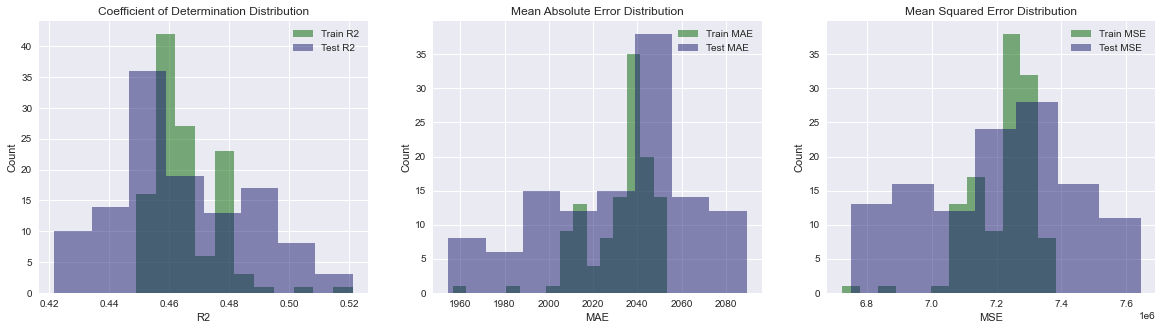

In [39]:
r2_train, r2_test, mae_train, mae_test, mse_train, mse_test = generate_score_distributions(load_multi_output_linear_SVR, PC_train, load_target_train, PC_test, load_target_test)

In [40]:
pv_r2_ttest = get_ttest_2samples(r2_train, r2_test)
pv_mae_ttest = get_ttest_2samples(mae_train, mae_test)
pv_mse_ttest = get_ttest_2samples(mse_train, mse_test)

p-value: 0.5577322782666123
fail to reject the null hypothesis
p-value: 0.9281370729379627
fail to reject the null hypothesis
p-value: 0.5283031344961786
fail to reject the null hypothesis


In [41]:
pv_r2_ztest = get_ztest_2samples(r2_train, r2_test)
pv_mae_ztest = get_ztest_2samples(mae_train, mae_test)
pv_mse_ztest = get_ztest_2samples(mse_train, mse_test)

p-value: 0.557175823523361
fail to reject the null hypothesis
p-value: 0.9280611380469151
fail to reject the null hypothesis
p-value: 0.5276970531430898
fail to reject the null hypothesis


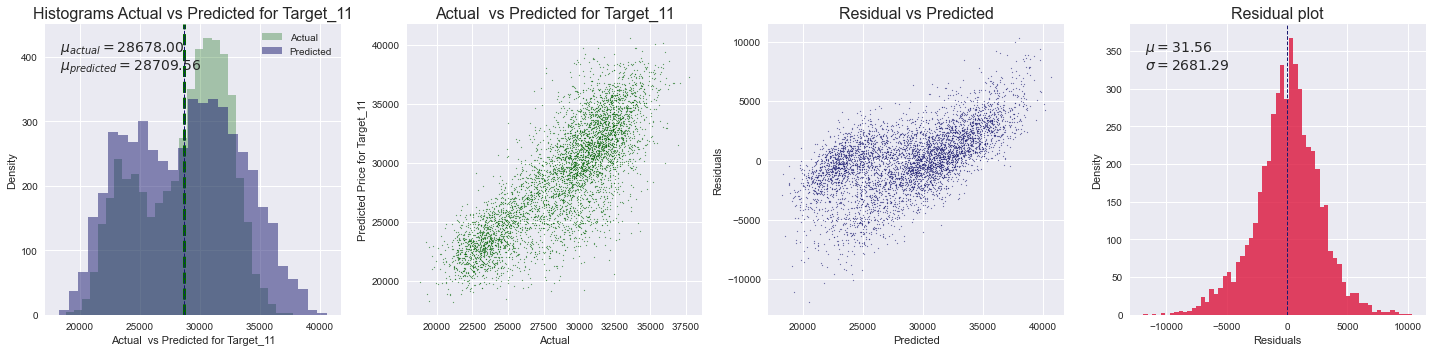

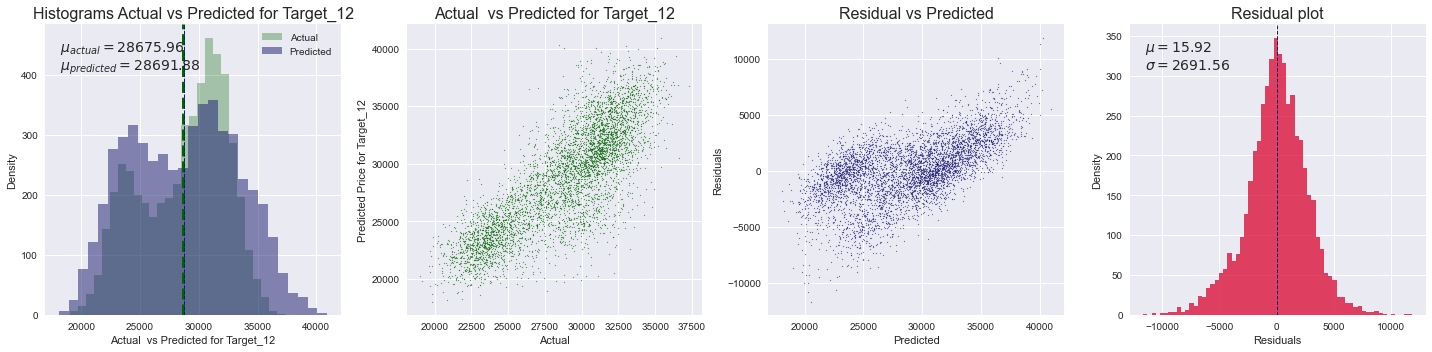

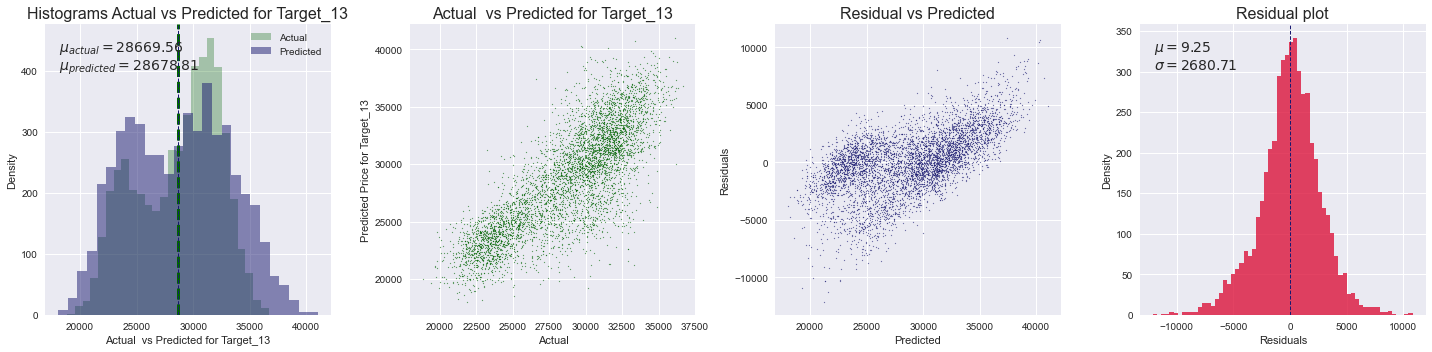

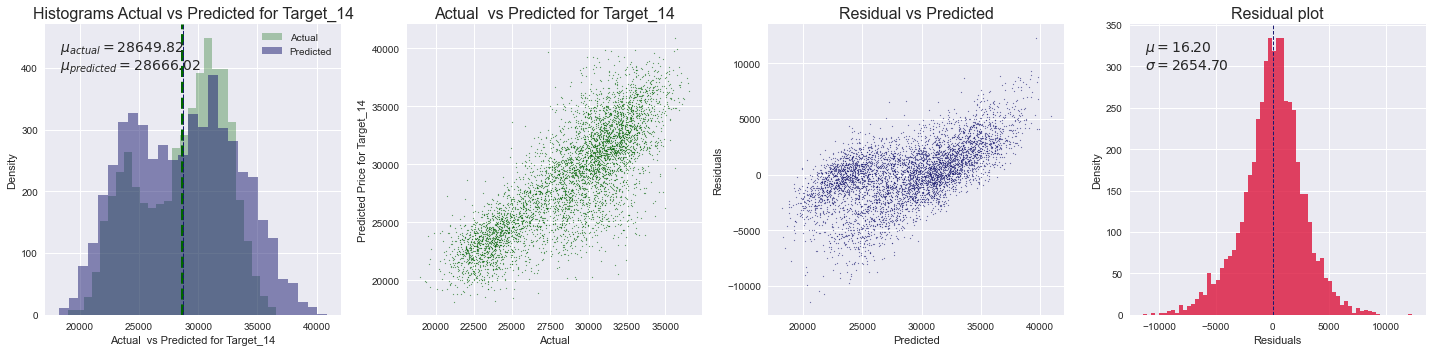

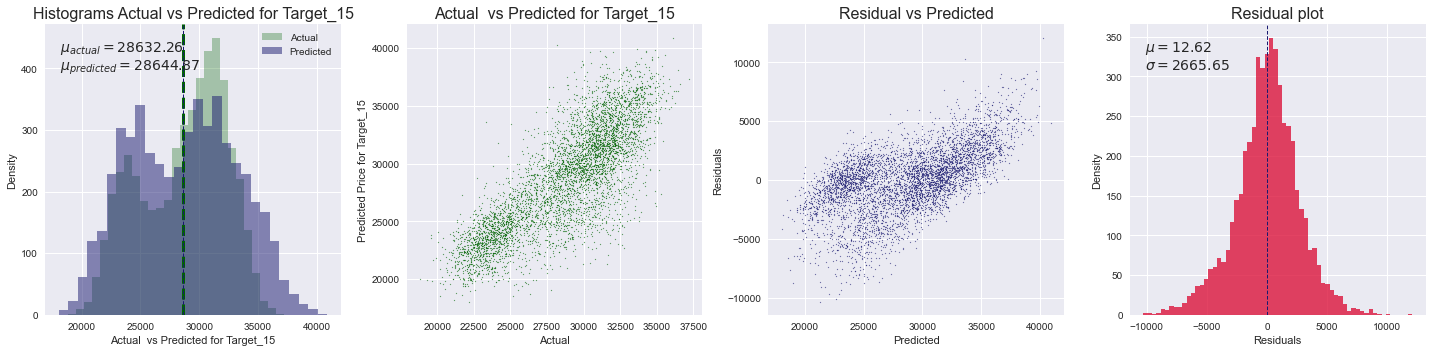

In [42]:
load_prediction = load_multi_output_linear_SVR.predict(PC_test)
e_minus_o = get_and_plot_data(load_prediction, load_target_test, start_index=10, stop_index=15)

In [43]:
print(get_ttest (load_prediction, load_target_test, idx=10))

p-value: 0.39926985084302014
we are accepting null hypothesis


In [44]:
print(get_ztest (load_prediction,load_target_test, idx=10))

p-value: 0.3992305488149209
accept null hypothesis


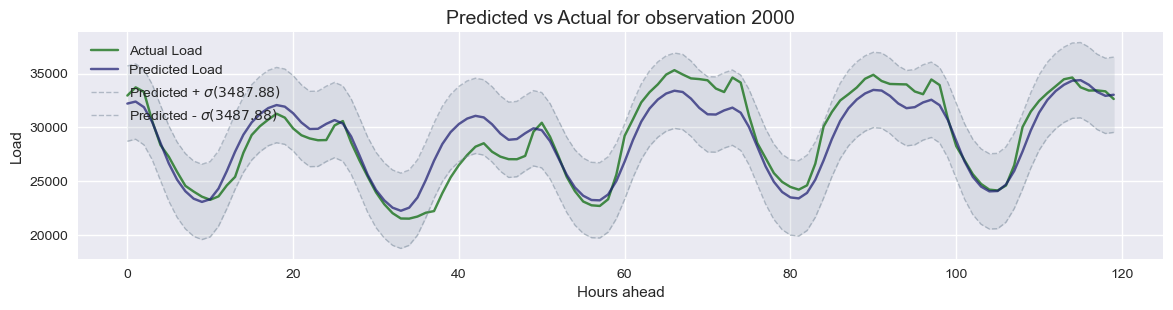

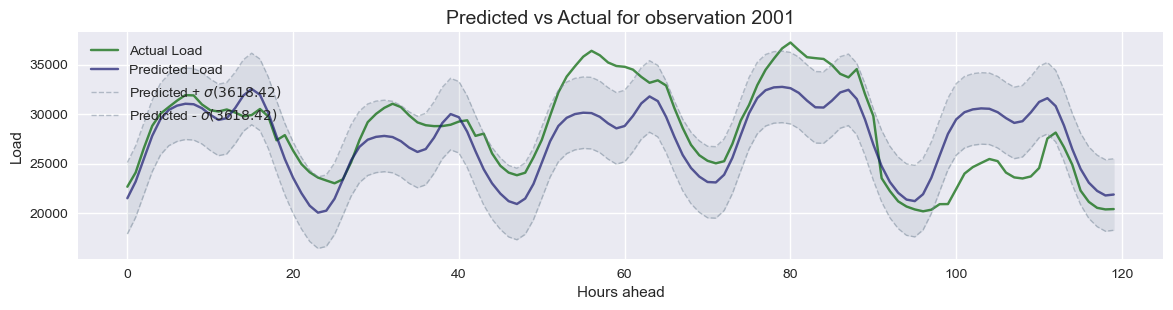

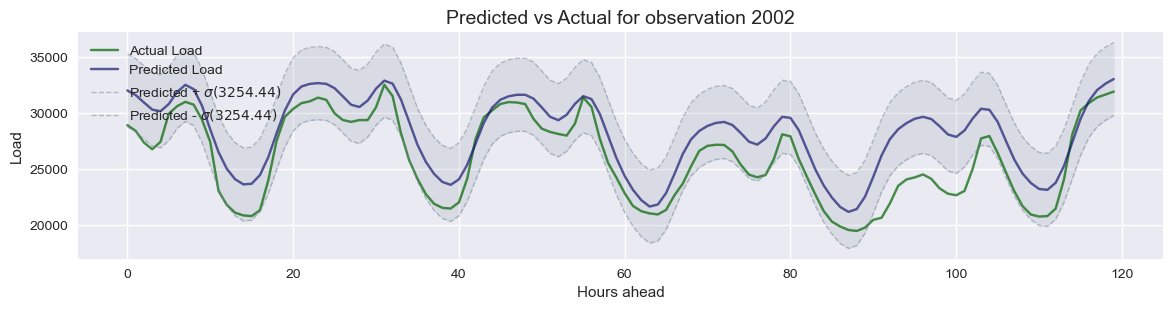

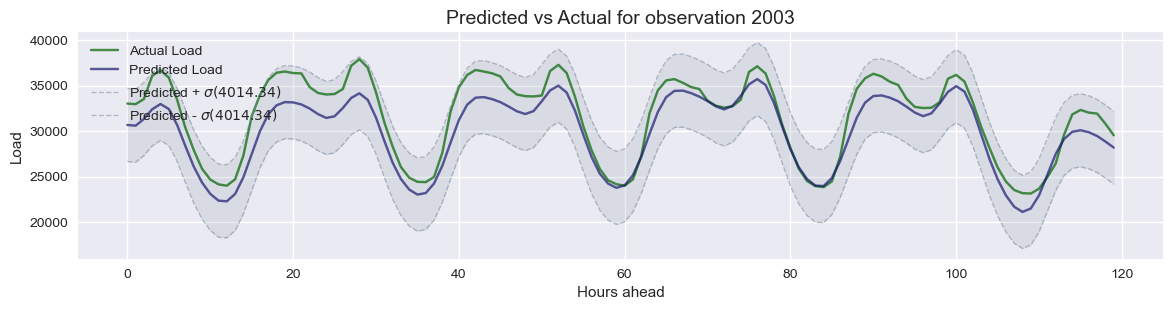

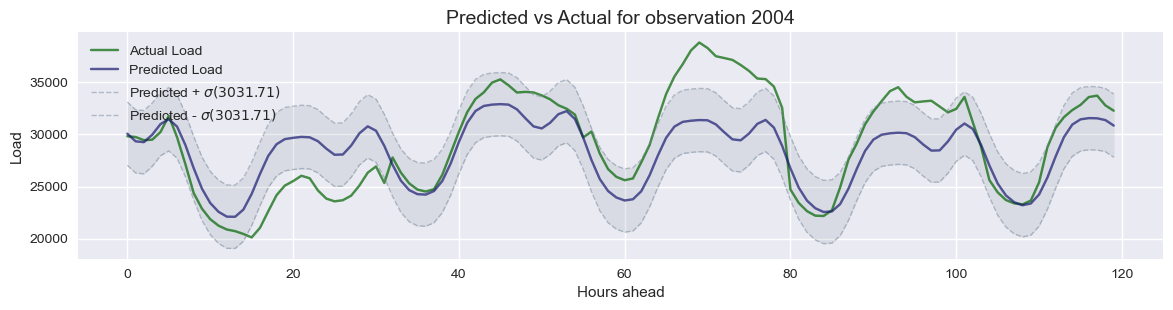

In [45]:
plot_actual_vs_prediction(load_prediction, load_target_test, variable_name = 'Load', start_inx = 2000, end_inx = 2005)

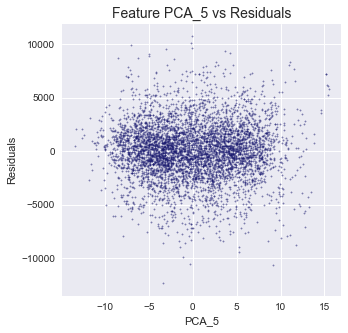

In [46]:
plot_feature_vs_residuals_PCA(PC_test, load_prediction, load_target_test, 
                              start_index=5, stop_index=6, target_indx = 1, col_name = None) 

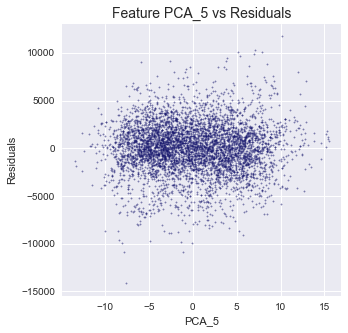

In [47]:
plot_feature_vs_residuals_PCA(PC_test, load_prediction, load_target_test, 
                              start_index=45, stop_index=52, target_indx = 119, col_name = 'PCA_5') 

Тестваме производителността върху всички данни. Видно е, че резултата не е по различен за сметка на времето за работа, което се увеличава многократно.

In [53]:
c = [ 0.001, 0.01,  0.1, 1, 10, 100] 
res_mo_svr = get_model_results(load_atribute_train, load_target_train, load_atribute_test, load_target_test, c, "MultiOutputRegressor")
res_mo_svr
# с всички данни

Function took 3679.7854 seconds


,mse_train,mae_train,rmse_train,r2_train,mse_test,mae_test,rmse_test,r2_test
C,,,,,,,,
0.001,7.089754e+06,2034.797060,2662.495066,0.658045,7.261356e+06,2058.808524,2694.263996,0.649468
0.010,6.841015e+06,1973.422650,2615.352589,0.670042,7.052387e+06,2004.219747,2655.138900,0.659555
0.100,6.836837e+06,1971.143935,2614.553258,0.670244,7.067384e+06,2004.661585,2657.954543,0.658830
1.000,6.836662e+06,1970.967702,2614.519775,0.670252,7.069601e+06,2004.848016,2658.372336,0.658723
10.000,6.836633e+06,1970.947254,2614.514389,0.670253,7.070038e+06,2004.885556,2658.453016,0.658702
100.000,6.836659e+06,1970.944862,2614.519089,0.670252,7.069678e+06,2004.823906,2658.389680,0.658719


In [54]:
res_mo_svr.to_csv("data/load_result_MOWrapper_LinearSVR_full_data.csv")

## Linear Support Vector Regression with Regressor Chain

### Search for Hyperparameters

In [32]:
c = [0.0001, 0.0005, 0.001, 0.01,  0.1, 1, 10, 100, 1000, 100000] 
res_rc_svr = get_model_results(PC_train, load_target_train, PC_test, load_target_test, c, "RegressorChain")
res_rc_svr
# с РСА трансформация на данните

Function took 433.2506 seconds


,mse_train,mae_train,rmse_train,r2_train,mse_test,mae_test,rmse_test,r2_test
C,,,,,,,,
0.0001,5.625983e+07,6080.988715,7431.422241,-1.713708,5.647017e+07,6084.560223,7444.321572,-1.725504
0.0005,3.577647e+07,4847.602778,5860.282215,-0.725744,3.603441e+07,4859.146703,5879.025787,-0.738924
0.0010,3.448291e+07,4766.887229,5748.166780,-0.663350,3.474931e+07,4780.178594,5767.809524,-0.676890
0.0100,3.365412e+07,4716.249305,5676.965485,-0.623374,3.392877e+07,4731.353054,5697.435193,-0.637283
0.1000,3.358998e+07,4712.435252,5671.563710,-0.620280,3.386548e+07,4727.730182,5692.116859,-0.634228
1.0000,3.358377e+07,4712.068118,5671.042607,-0.619981,3.385935e+07,4727.382443,5691.603999,-0.633933
10.0000,3.358314e+07,4712.030886,5670.990202,-0.619950,3.385874e+07,4727.347217,5691.552475,-0.633903
100.0000,3.358309e+07,4712.028704,5670.986195,-0.619948,3.385869e+07,4727.345064,5691.548418,-0.633900
1000.0000,3.358308e+07,4712.028025,5670.985383,-0.619948,3.385868e+07,4727.344443,5691.547642,-0.633900


In [33]:
res_rc_svr.to_csv("data/load_result_RCWrapper_LinearSVR.csv")

Coefficient of determination е по-малък от нула, което показва, че модела е прекалено слаб. Това означава, че всеки модел, който дава средното е по-добър от нашия. 

In [46]:
@timeit
def chain_linear_svr(att, target):
    svr = LinearSVR(C=10, max_iter = 1000, tol = 0.001, random_state=42, loss='squared_epsilon_insensitive', dual=False)
    svr_wrapped = RegressorChain(svr)
    svr_wrapped.fit(att, target)            
    return svr_wrapped

load_chain_linear_SVR = chain_linear_svr(PC_train, load_target_train)

Function took 38.7329 seconds


In [47]:
save_model(load_chain_linear_SVR, "#load_svr_rchain_optimal_model.sav")

In [48]:
_, _, _ = evaluation_report(load_chain_linear_SVR, PC_train, load_target_train)

Score Results:
Mean squared error: 33583143.36
Root mean squared error: 5670.99
Mean absolute error: 4712.03
Coefficient of determination: -0.6200
Predicted mean: 27921.434 (3661.569)


In [49]:
_, _, _ = evaluation_report(load_chain_linear_SVR, PC_test, load_target_test)

Score Results:
Mean squared error: 33858739.67
Root mean squared error: 5691.55
Mean absolute error: 4727.35
Coefficient of determination: -0.6339
Predicted mean: 27944.565 (3678.105)


In [52]:
c = [0.0001, 0.0005, 0.001, 0.01,  0.1, 1, 10, 100, 1000, 100000] 
res_rc_svr = get_model_results(load_atribute_train, load_target_train, load_atribute_test, load_target_test, c, "RegressorChain")
res_rc_svr
# с всички данни

Function took 2346.8891 seconds


,mse_train,mae_train,rmse_train,r2_train,mse_test,mae_test,rmse_test,r2_test
C,,,,,,,,
0.0001,5.626899e+07,6082.839434,7431.610923,-1.714154,5.668156e+07,6098.122249,7458.162748,-1.735700
0.0005,3.597796e+07,4856.641462,5876.506252,-0.735467,3.632270e+07,4872.837276,5902.143352,-0.752835
0.0010,3.472899e+07,4777.995013,5768.658252,-0.675226,3.508481e+07,4796.008240,5795.468760,-0.693079
0.0100,3.398539e+07,4732.260780,5705.442965,-0.639359,3.438025e+07,4753.941763,5735.980592,-0.659072
0.1000,3.393288e+07,4729.124606,5701.147946,-0.636826,3.433347e+07,4751.295324,5732.229040,-0.656814
1.0000,3.392947e+07,4728.799620,5700.868416,-0.636662,3.432993e+07,4750.992203,5731.985089,-0.656643
10.0000,3.393796e+07,4729.474144,5701.608952,-0.637071,3.433973e+07,4751.739585,5732.792366,-0.657117
100.0000,3.393723e+07,4729.300705,5701.545658,-0.637036,3.434102e+07,4751.709854,5732.935699,-0.657178
1000.0000,3.392773e+07,4728.822843,5700.734340,-0.636577,3.432911e+07,4751.058968,5731.891439,-0.656604


In [ ]:
res_rc_svr.to_csv("data/load_result_RCWrapper_LinearSVR_full_data.csv")